# 物品检测

| 更新时间 | 负责人 | 内容 | 备注 |
| --- | --- | --- | --- |
| 2021年12月2日 | Rui | 初次编写文档 | ---- |
| 2022年12月15日 | Rui | 修改文档的编写方式 | 使用 Jupyter notebook 进行编写文档 |
| 2022年1月18日 | Rui | 修改文档，增加效果图 | 通过测试的平台有 MaixII-Dock，使用的是 MaixPy3 0.4.0 |
| 2022年3月18日 | Rui | 在 MaixSense 上使用测试通过 | 需要将 MaixPy3 更新到 0.4.5 以上 |
| 2022年3月29日 | Rui | 添加 MaixII-Dock Yolo-V2 20分类 | 模型及代码下载：[Github 下载](https://github.com/Abandon-ht/Maix-II-Dock-model.git)<br>作者：小老鼠 |

物品检测，即目标检测，简单的来说就是可以框选出画面中的目标物体并输出坐标位置。通过不同的数据集来实现不同的目标识别，以下分别使用人脸数据集和 Yolo 标准数据集进行训练得出的目标检测模型。


## 运行效果

<p align="center">
<iframe src="//player.bilibili.com/player.html?aid=720490332&bvid=BV15Q4y1r7HV&cid=405128041&page=1" scrolling="no" border="0" frameborder="no" framespacing="0" allowfullscreen="true" style="max-width:640px; max-height:480px;"> </iframe>
</p>

## 准备

- 使用的硬件为 MaixII-Dock 或 MaixSense
- 获取模型文件，`MaixII-Dock` 可以在 [MaixHub](https://www.maixhub.com/modelInfo?modelId=26) 上获取或者烧录最新版本的系统镜像；`MaixSense` 则是需要烧录最新的 armbian 系统镜像到内存卡上。
- 确认 MaixPy3 版本为 0.4.3 以上
- 插卡启动硬件



## 在 MaixII-Dock 上部署目标检测

2022年后系统内置了模型文件 `/home/model/face/yolo2_face_awnn.*`）

### 部署人脸目标检测网络模型

In [1]:
global Yolo
class Yolo:
    labels = ["person"]
    anchors = [1.19, 1.98, 2.79, 4.59, 4.53, 8.92, 8.06, 5.29, 10.32, 10.65]
    m = {
        "param": "/home/model/face/yolo2_face_awnn.param",
        "bin": "/home/model/face/yolo2_face_awnn.bin"
    }
    options = {
        "model_type":  "awnn",
        "inputs": {
            "input0": (224, 224, 3)
        },
        "outputs": {
            "output0": (7, 7, (1+4+len(labels))*5)
        },
        "mean": [127.5, 127.5, 127.5],
        "norm": [0.0078125, 0.0078125, 0.0078125],
    }
    def __init__(self):
        from maix import nn
        from maix.nn import decoder
        self.model = nn.load(self.m, opt=self.options)
        self.decoder = decoder.Yolo2(len(self.labels), self.anchors, net_in_size=(224, 224), net_out_size=(7, 7))
    def __del__(self):
        del self.model
        del self.decoder
print(Yolo)


[ rpyc-kernel ]( running at Thu Jan 20 13:46:59 2022 )


### 运行网络模型，进行目标检测

上面已经将模型文件加载部署到系统中，下面只需要对模型文件进行解码，获取目标在画面中的位置并框选出来

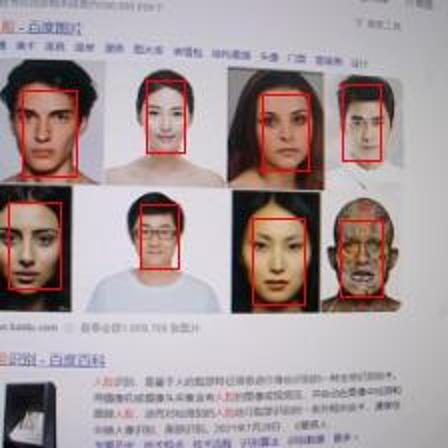

In [ ]:
from maix import camera, display
yolo = Yolo()
print(yolo)
while True:
    img = camera.capture().resize(224, 224)
    out = yolo.model.forward(img, quantize=True, layout="hwc")
    boxes, probs = yolo.decoder.run(out, nms=0.3, threshold=0.5, img_size=(224, 224))
    if len(boxes):
        for i, box in enumerate(boxes):
            img.draw_rectangle(box[0], box[1], box[0]+box[2], box[1]+box[3], (255,0,0), 1)
        display.show(img)
    else:
        display.show(img)


## 在 MaixSense 上部署目标检测

可以用于识别 labels 中的物品类型。

> 最新版本的 Armbian 系统已经将模型内置到了 `/home/model/` 中，Tina 系统目前不提供支持。

### 部署网络模型

In [ ]:
global Yolo
class Yolo:
    labels = ["aeroplane","bicycle","bird","boat","bottle","bus","car","cat","chair","cow","diningtable","dog","horse","motorbike","person","pottedplant","sheep","sofa","train","tvmonitor"]
    anchors = [0.4165, 0.693 , 0.9765, 1.6065, 1.5855, 3.122 , 2.821 , 1.8515 , 3.612 , 3.7275]
    m = {
        "bin": "/home/model/aipu_yolo_VOC2007.bin"
    }
    options = {
        "model_type":  "aipu",
        "inputs": {
            "input0": (224, 224, 3)
        },
        "outputs": {
             "output0": (7, 7, (1+4+len(labels))*5)
        },
        "mean": [127.5, 127.5, 127.5],
        "norm": [0.0078125, 0.0078125, 0.0078125],
        "scale":[8.031941],
    }
    def __init__(self):
        from maix import nn
        from maix.nn import decoder
        self.model = nn.load(self.m, opt=self.options)
        self.decoder = decoder.Yolo2(len(self.labels), self.anchors, net_in_size=(224, 224), net_out_size=(7, 7))
    def __del__(self):
        del self.model
        del self.decoder
print(Yolo)


### 运行网络模型，进行目标检测

上面已经将模型文件加载部署到系统中，下面只需要对模型文件进行解码，获取目标在画面中的位置并框选出来

In [ ]:
from maix import camera, display
yolo = Yolo()
print(yolo)
while True:
    img = camera.capture().resize(224,224)
    out = yolo.model.forward(img, quantize=True, layout="chw")
    boxes, probs = yolo.decoder.run(out, nms=0.5, threshold=0.5, img_size=(224, 224))
    if len(boxes):
        for i, box in enumerate(boxes):
            class_id = probs[i][0]
            prob = probs[i][1][class_id]
            disp_str = "{}:{:.2f}%".format(yolo.labels[class_id], prob*100)
            img.draw_rectangle(box[0], box[1], box[0]+box[2], box[1]+box[3], (255,0,0), 1)
            img.draw_string(box[0], box[1]+ box[3] ,disp_str, scale=0.5,color=(0, 0, 255), thickness=1)
        display.show(img)
    else:
        display.show(img)


## 网络模型训练
查看左边目录中的 【训练AI模型】 学习如何训练属于自己的目标检测模型